# Weibo

In this part we will try to replicate the figures 1A, 2A and 2B of the twitter propositions paper.

In [55]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import timezone, timedelta

## Replication of the Figure 1A with the Weibo dataset.

For this first replication we use a dataset containing users (including users with 0 post) and all their posts.

In [56]:
# First, we import all the post of the users with "latin" encoding to resolve coding problems. Dtype was precised to avoid warnings.
data_weibo = pd.read_csv('week1.csv', encoding= 'latin', dtype={'permission_denied': str})
data_weibo.sample(5)

,mid,retweeted_status_mid,uid,retweeted_uid,source,image,text,geo,created_at,deleted_last_seen,permission_denied
2398027,mevV1GT1jl,m6EpRgO1zW,u3JH1O0YC,NaN,æ°æµªå¾®å,0,å¿«é»è¨»åå§;)//@uB5N40H35ï¼ æåä¾æª...,NaN,2012-01-02 17:00:32,NaN,NaN
3629145,mEjnq9nCMO,m9IpHhyRQo,u3511XAB5,NaN,æ°æµªå¾®å,0,//@uONPVZMM1ï¼ è¿å¯¹æ¯çèµ·æ¥çè®©äººå¿...,NaN,2012-01-07 17:51:54,NaN,NaN
1764483,mH42b0PXr1,mfsUxbL6TY,u0Y1R4ZJB,NaN,æ°æµªå¾®å,0,åå¤@uknï¼ æ¨æçå®ï¼éå¸¸å¥½çï¼[é...,NaN,2012-01-05 10:52:14,NaN,NaN
807875,mzqhIhRqTb,NaN,uQSMA2AH5,NaN,æ°æµªå¾®å,0,"Never frown,even when you are sad,becauce you ...",NaN,2012-01-02 15:33:26,NaN,NaN
2317765,mQW0Lns9MA,mppTdtbQCH,uKB50XZ1X,NaN,æ°æµªå¾®å,0,//@uPKFJH1RCï¼ //@uONPVZMM1ï¼ å¤§ç±çå­...,NaN,2012-01-04 14:14:06,NaN,NaN


This first dataframe contain all the posts, but doesn't contain all the users, so we must load the second dataset with the corresponding users and merge the two datasets.

In [57]:
weibo_users = pd.read_csv('userdata.csv')
weibo_users.sample(5)

,uid,province,gender,verified
1274003,uR1WDOKF4,31,f,False
2600660,uQSMQSJHT,34,m,False
4890072,u1O52VMSJ,51,f,False
12740067,uR1W3HYC3,100,m,False
4771954,u0VPSHJTU,33,m,False


Now we can concatenate the two datasets.

In [58]:
# We group the first dataset by user id.
actif_wusers = data_weibo.groupby(["uid"]).size()

# we concatenate the two dataset by their "uid", keep only the number of post by user. Here the "Nan" represent people with 0 post, so we replace "Nan" by 0.
Egos = pd.concat([actif_wusers, weibo_users["uid"]], axis=1, sort=False).iloc[:, 0].fillna(0)

We just need to define the CCDF function and then we can directly plot the graph.

In [59]:
def get_ccdf(vals):
    # Input:
    # -- vals: an np.array of integers greater or equal to 0 ( this method doesn't include the value for the number of tweet = 0, 
    # we could eventually manually add it, but wee will understand better the problem in the analysis of the results just below and how this is corrected)
    # Output:
    # -- x: an array containing all numbers from 1 to max(vals) + 2;
    # -- y: an array containing the (empirically calculated) probability that vals >= x
    
    # bincount count number of occurrences for each value in the array so we must give all the range of vals
    y = np.cumsum(np.bincount(vals)) 
    y = y/y[-1]
    
    # Take the complementary probability, so it give us the probability that vals >= x
    y = 1-y 
    
    x = list(range(1, max(vals) + 2))
    
    return x, y

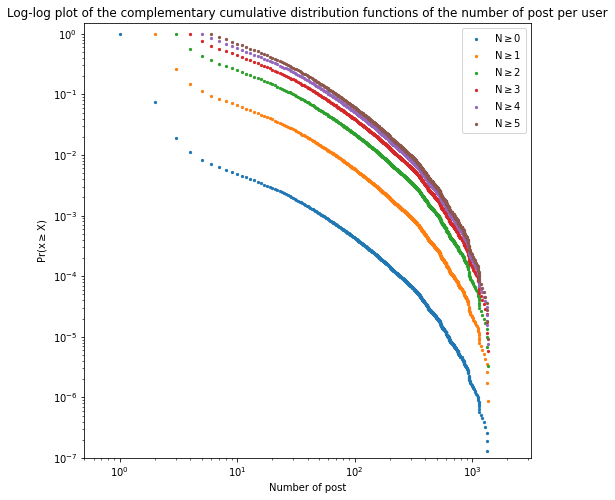

In [60]:
f, ax = plt.subplots(figsize=(8, 8))
first_values = []
for i in range(6):
    # We calculate the CCDF for the different N with a shift of +1.
    x, y = get_ccdf(Egos[Egos>=i].astype(int) + 1 )
    Ego_ccdf = pd.DataFrame({'ccdf': y}, index = x) 
    Ego_ccdf = Ego_ccdf.drop_duplicates(subset = "ccdf", keep="last")
    ax.scatter(Ego_ccdf.index, Ego_ccdf.ccdf, s = 5, label="N$\geq${}".format(i))
    first_values.append(Ego_ccdf[0:i-6])
    
ax.legend()
ax.set_xlim((0.5,10**3.5))
ax.set_ylim((10**-7,1.5))
ax.set(xscale="log", yscale="log")
ax.set_xlabel('Number of post')
ax.set_ylabel('Pr(x$\geq$X)')
ax = ax.set_title("Log-log plot of the complementary cumulative distribution functions of the number of post per user")

The CCDF seems convincing and look coherent relatively to the other social networks.
However, it is important to note that the time frame over which the messages were taken is only one week. So it is not so surprising to see such a high proportion of users who have not shared any posts.

We save the dataset for later additional computations.

In [ ]:
Egos_csv = Egos.sort_values(ascending=False, ignore_index = True)
Egos_csv.astype("int16").to_csv('weibo_power_law.csv')

## Replication of the Figure 2A and 2B: The cyrdian rythm of the day, with the second dataset

For this second replication we will use another dataset. Indeed since the first dataset contains only the posts over one week, it is not very representative to replicate the figures 2 and it creates discontinuities in the graph. The second dataset, although it does not contain any user with 0 post and contains globally less post, contains posts over several years. So it will should give way better results for this task.

In [61]:
# First, we import all the post of the users with "latin" encoding to resolve coding problems.
data_weibo2 = pd.read_csv('user_post.csv', encoding= 'latin')
data_weibo2.sample(5)

,post_id,post_time,content,poster_id,poster_url,repost_num,comment_num,repost_post_id,inner_flag
31629,3.770930e+15,2014/10/29 8:45,¿ªÐÄÊÇ³¡Æ­¾Ö£¬ÎÒ¶¥¶àËã¸öÎÔµ×¡£http://t.cn/R7orgSX,3.043435e+09,http://weibo.com/3043434564,0.0,0.0,NaN,NaN
16703,3.538050e+15,2013/1/24 17:20,ÎÒÃÇÔÚÕâ¶ùË¼¿¼ÈËÉú¡£¡£Ë¼¿¼ÀíÏë¡£¡£@yang-yang@Á...,1.772991e+09,http://weibo.com/1772990520,0.0,6.0,NaN,NaN
749,3.716980e+15,2014/6/2 11:46,2014Äê´ºÏÄÐÂ¿î°¢µÏ´ïË¹NEOÏµÁÐÊ±ÉÐÇéÂÂµÍ°ï·´Ã«Æ...,3.864109e+09,http://weibo.com/3864109310,0.0,0.0,NaN,NaN
36620,3.756070e+15,2014/9/18 8:50,¸ßÀäÒ»µã£¬¾ÍºÃ,2.399361e+09,http://weibo.com/2399360981,0.0,0.0,NaN,
44664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can now filter our dataset to remove unusable data.

In [62]:
# We make sur to remove all the data that doesn't contain the post time.
data_weibo2 = data[data['post_time'].notna()]

Then, we process the data in order to have the day of the week and the hour on which the posts were created.

In [63]:
data_corrected = data_weibo2.copy()
data_corrected['dated'] = pd.to_datetime(data_corrected['post_time'])

# We create two new columns containing the day and the hour at which the tweet was posted.
data_corrected['Weekday']  = data_corrected['dated'].apply(lambda x: x.weekday())
data_corrected['Hour'] = data_corrected['dated'].apply(lambda x: x.strftime('%H'))

In [64]:
# We can directly group the number of tweet by day and by hour interval.
daily_post = data_corrected.groupby(["Weekday","Hour"]).size()

# We first group the number of tweets by user, by day and by hour. 
# Then we can get the number of user there is for each day and hour interval. 
daily_users = data_corrected.groupby(["Weekday","Hour","poster_id"]).sum()
daily_users = daily_users.groupby(["Weekday","Hour"]).size()

With this dataset we can now try to plot the figure 2A and 2B in order to check the cyrcadian rythm of the day.

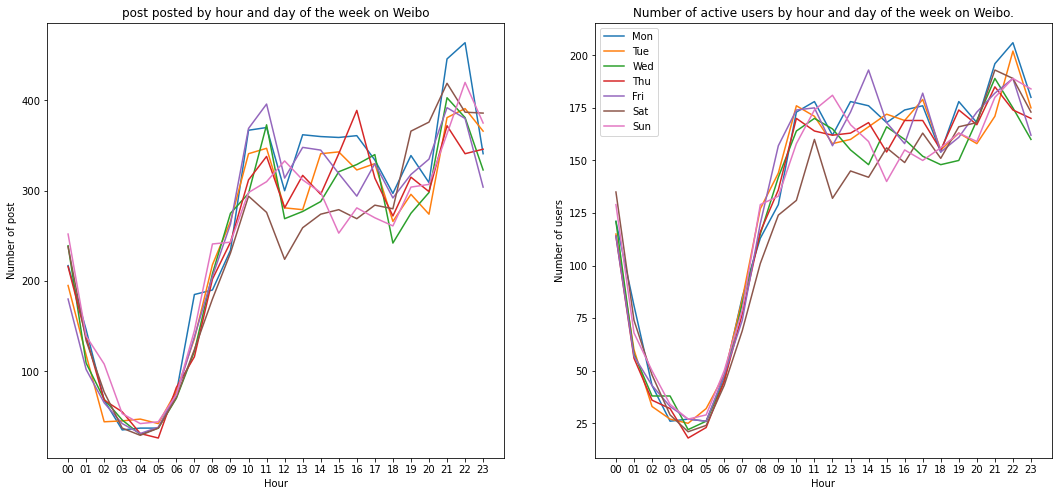

In [65]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
days = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
for day in range(7):
    ax[0].plot(daily_post[day])
    ax[1].plot(daily_users[day],label=days[day])
    
ax[0].set_xlabel('Hour')
ax[0].set_ylabel('Number of post')
ax[0].set_title("post posted by hour and day of the week on Weibo")

ax[1].legend()
ax[1].set_xlabel('Hour')
ax[1].set_ylabel('Number of users')
ax[1] = ax[1].set_title("Number of active users by hour and day of the week on Weibo.")

The results seem coherent. We notice that contrary to most other social networks, for Weibo there is not a drop in the usage during weekends.

Finally, we save the dataset as a csv for later addiotional computation.

In [6]:
data_corrected[["poster_id","Weekday","Hour"]].to_csv('weibo_cyrcadian.csv')